# Setup

In [1]:
import os
import numpy as np
import rasterio
import geopandas as gpd
from rasterio import features
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_raster(path):
    """Load raster and return array + profile."""
    src = rasterio.open(path)
    arr = src.read(1)
    profile = src.profile
    return arr, profile

def save_raster(path, array, profile):
    """Save raster with given profile."""
    profile.update(dtype=rasterio.uint8, count=1)
    with rasterio.open(path, "w", **profile) as dst:
        dst.write(array.astype("uint8"), 1)

def rasterize_shapefile(gdf, reference_profile, attribute):
    """Rasterize shapefile according to reference raster."""
    shapes = [(geom, value) for geom, value in zip(gdf.geometry, gdf[attribute])]
    raster = features.rasterize(
        shapes=shapes,
        out_shape=(reference_profile["height"], reference_profile["width"]),
        transform=reference_profile["transform"],
        fill=0,
        dtype="uint8"
    )
    return raster

In [ ]:
PATCH_SIZE = 128  # can change to 64 or 256
BATCH_SIZE = 8
EPOCHS = 30

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

NUM_FEATURE_BANDS = 8

Using device: cpu


# Load data

In [4]:
BASE_DIR = r"data/12-training-data"

# Feature rasters live directly inside BASE_DIR
FEATURE_DIR = os.path.join(BASE_DIR, "input")
OUTPUT_DIR = os.path.join(BASE_DIR, "output")

DEPENDENT_DIR = os.path.join(FEATURE_DIR, "dependent-data-urban-no")
LANDCOVER_DIR = os.path.join(FEATURE_DIR, "final-data-land-cover")


In [5]:
rasters_2019 = {
    "NDVI": os.path.join(FEATURE_DIR, "NDVI_2019.tif"),
    "NDBI": os.path.join(FEATURE_DIR, "NDBI_2019.tif"),
    "MNDWI": os.path.join(FEATURE_DIR, "MNDWI_2019.tif"),
    "BSI": os.path.join(FEATURE_DIR, "BSI_2019.tif"),
    "DEM": os.path.join(FEATURE_DIR, "DEM-DAegu-merged-clipmask.tif"),
    "slope": os.path.join(FEATURE_DIR, "slope.tif"),
    "hillshade": os.path.join(FEATURE_DIR, "hillshade.tif"),
    "night": os.path.join(FEATURE_DIR, "VNL_2019_daegu_clipped.tif"),
    "ecology": os.path.join(FEATURE_DIR, "env-assessment-data-2019.tif"),
}

In [6]:
feature_arrays = {}
feature_profiles = {}

print("Loading 2019 rasters...\n")

for name, path in rasters_2019.items():
    arr, profile = load_raster(path)
    feature_arrays[name] = arr
    feature_profiles[name] = profile
    print(f"{name} loaded → shape: {arr.shape}")


Loading 2019 rasters...

NDVI loaded → shape: (4531, 3714)
NDBI loaded → shape: (4531, 3714)
MNDWI loaded → shape: (4531, 3714)
BSI loaded → shape: (4531, 3714)
DEM loaded → shape: (1622, 1330)
slope loaded → shape: (1622, 1330)
hillshade loaded → shape: (1622, 1330)
night loaded → shape: (99, 100)
ecology loaded → shape: (4590, 3684)


In [7]:
urb19_path = os.path.join(DEPENDENT_DIR, "landcover_2019_urban_binary.shp")
urb24_path = os.path.join(DEPENDENT_DIR, "landcover_2024_urban_binary.shp")

gdf_urb19 = gpd.read_file(urb19_path)
gdf_urb24 = gpd.read_file(urb24_path)

print("Urban 2019 polygons:", len(gdf_urb19))
print("Urban 2024 polygons:", len(gdf_urb24))


Urban 2019 polygons: 332700
Urban 2024 polygons: 923467


In [8]:
lc19_path = os.path.join(LANDCOVER_DIR, "landcover_2019_final.shp")
lc24_path = os.path.join(LANDCOVER_DIR, "landcover_2024_final.shp")

gdf_lc19 = gpd.read_file(lc19_path)
gdf_lc24 = gpd.read_file(lc24_path)

print("Landcover 2019 classes:", len(gdf_lc19))
print("Landcover 2024 classes:", len(gdf_lc24))

Landcover 2019 classes: 332700
Landcover 2024 classes: 923467


In [9]:
reference_profile = feature_profiles["NDVI"]
print("\nReference raster info:")
print("  Size:", reference_profile["height"], "x", reference_profile["width"])
print("  CRS:", reference_profile["crs"])
print("  Resolution:", reference_profile["transform"][0])


Reference raster info:
  Size: 4531 x 3714
  CRS: EPSG:32652
  Resolution: 10.0


# Rasterize urban shapefile

In [10]:
urban_2019_raster_path = os.path.join(OUTPUT_DIR, "urban_2019.tif")
urban_2024_raster_path = os.path.join(OUTPUT_DIR, "urban_2024.tif")

In [17]:
# Reproject urban shapefile to match raster CRS
target_crs = reference_profile["crs"]

gdf_urb19 = gdf_urb19.to_crs(target_crs)
gdf_urb24 = gdf_urb24.to_crs(target_crs)

print("Reprojection complete.")

Reprojection complete.


In [18]:
urban2019_raster = rasterize_shapefile(
    gdf=gdf_urb19,
    reference_profile=reference_profile,
    attribute="UrbanBinar" 
)

save_raster(urban_2019_raster_path, urban2019_raster, reference_profile)

In [19]:
gdf_urb19.columns

Index(['L1_CODE', 'L1_NAME', 'L2_CODE', 'L2_NAME', 'L3_CODE', 'L3_NAME',
       'IMG_NAME', 'IMG_DATE', 'LU_INFO', 'ETC_INFO', 'ENV_INFO', 'FOR_INFO',
       'UD_INFO', 'INX_NUM', 'L2_NAME_EN', 'L2_NAME__1', 'UrbanBinar',
       'geometry'],
      dtype='object')

In [20]:
urban2024_raster = rasterize_shapefile(
    gdf=gdf_urb24,
    reference_profile=reference_profile,
    attribute="UrbanBinar" 
)

save_raster(urban_2024_raster_path, urban2024_raster, reference_profile)


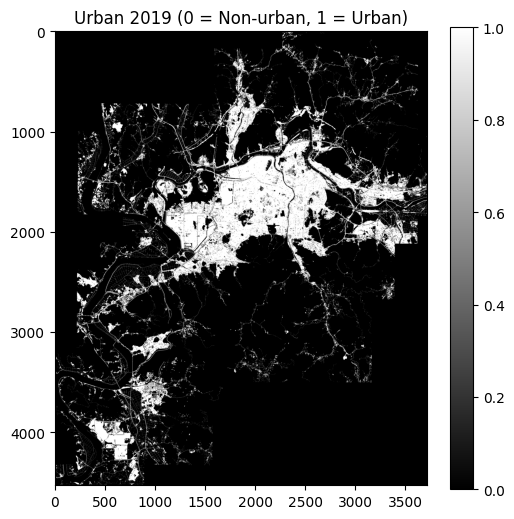

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(urban2019_raster, cmap="gray")
plt.title("Urban 2019 (0 = Non-urban, 1 = Urban)")
plt.colorbar()
plt.show()

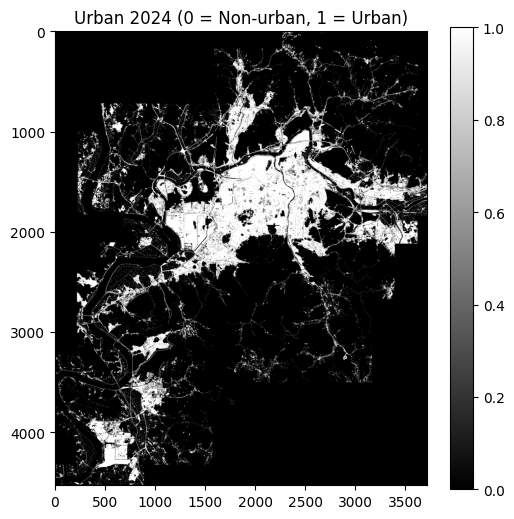

In [22]:
plt.figure(figsize=(6,6))
plt.imshow(urban2024_raster, cmap="gray")
plt.title("Urban 2024 (0 = Non-urban, 1 = Urban)")
plt.colorbar()
plt.show()

In [23]:
print(reference_profile["crs"])
print(gdf_urb19.crs)

EPSG:32652
PROJCS["WGS 84 / UTM zone 52N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",129],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32652"]]


In [24]:
gdf_urb19.columns
gdf_urb19.head()

,L1_CODE,L1_NAME,L2_CODE,L2_NAME,L3_CODE,L3_NAME,IMG_NAME,IMG_DATE,LU_INFO,ETC_INFO,ENV_INFO,FOR_INFO,UD_INFO,INX_NUM,L2_NAME_EN,L2_NAME__1,UrbanBinar,geometry
0,100,시가화건조지역,110,주거지역,111,단독주거시설,항공정사영상,2017-12-31,None,None,None,None,None,35802027,Residential Area,Residential Area,1,"POLYGON ((446436.077 3975792.794, 446419.96 39..."
1,100,시가화건조지역,110,주거지역,111,단독주거시설,항공정사영상,2017-12-31,None,None,None,None,None,35802027,Residential Area,Residential Area,1,"POLYGON ((446818.046 3975790.499, 446805.617 3..."
2,100,시가화건조지역,110,주거지역,111,단독주거시설,항공정사영상,2017-12-31,None,None,None,None,None,35802027,Residential Area,Residential Area,1,"POLYGON ((446877.74 3975824.136, 446877.108 39..."
3,100,시가화건조지역,110,주거지역,111,단독주거시설,항공정사영상,2017-12-31,None,None,None,None,None,35802027,Residential Area,Residential Area,1,"POLYGON ((446569.503 3975838.843, 446552.579 3..."
4,100,시가화건조지역,110,주거지역,111,단독주거시설,항공정사영상,2017-12-31,None,None,None,None,None,35802027,Residential Area,Residential Area,1,"POLYGON ((446831.088 3975828.466, 446823.433 3..."
